# Homework 1, EDS 220
## Practice with Data Manipulation

This template provides the instructions for EDS 220 HW1, and some initial environment loading/package configuration commands which you are welcome to modify as needed. 

**You will need to supply your own code for this assignment! Feel free to cut and paste relevant lines from the course materials or elsewhere online, that's what coding is all about.**

**You may work in teams for this assignment, but no more than 3 people/team.**

### 0) Some hints to get you started

This assignment is designed to be doable using the codes we've worked with in class so far, plus a bonus notebook I put together to demonstrate how to extract data from a Google Earth Engine ImageCollection and turn it into a Pandas DataFrame. Good places to look for example codes (in the main class repo unless otherwise specified):
- _Time series extraction_: "ExampleCommands_GEEDataExtraction_HW1" (in the HW1 repo)
- _Histogram creation_: "HistogramKDE_precipitation_example"
- _GEE map creation_: "NDVI_Landsat_GEE"
- _Map projection with Cartopy_: "Cartopy_examples", "GEE_mapprojections_MODIS"
- _NDVI mapping_: "NDVI_Landsat_GEE"

You DO NOT HAVE to use those examples, however - code from anywhere is fair game, as long as it runs correctly!

### 1. Choose A Study Region

Think about places on Earth that you're interested in. This could be anywhere: Santa Barbara, your hometown, a place you always wanted to visit, you name it. 

For that place, then consider what it is like. Is it urban? Rural? Temperate? Tropical? Write a brief (1-2 paragraph) description of the local climate and population (if applicable).

### Region of choice: Seattle, WA

Seattle is an urban metro area with about 730,000. The city is surrounded by Puget Sound (seawater) and freshwater lakes (Lake Washington and Lake Union). Open spaces in and around the city are typically covered with evergreen forests. In the regions beyond the city and suburbs, there's agricultural land and mountians. 

The climate in seattle is rainy and temperate. The city recieves about 37 inches of annual rainfall. Rainfall patters in western washington are heavily affected by the Olympic mountain range to the West, which blocks a lot of moisture from regions Northeast of the mountains (in the "rainshadow"). Rainfall is heavier in the "convergence zone" just west of the Cascade mountains where incoming moisture from the west is trapped against the mountians. 

The average temperatures in Seattle range from an average monthly high of 74°F in August and an average monthly low of 36°F in January and December. In recent years, summers have been much hotter and drier than average. Fluctuations between high and low temperatures are relatively small. 

In [2]:
# Import packages - ADDED CARTOPY
import ee
import geemap
from geemap import cartoee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

### 2. Locate A Precipitation Dataset

Look through the Google Earth Engine data catalog:
    https://developers.google.com/earth-engine/datasets
    
To keep things simple (ish), we'll stick with precipitation as our major climate variable. Precip is nice because there are lots of interesting spatial patterns that are easy to see without doing too much data processing! 

a. Choose one of the precipitation datasets available in GEE, any one you like. Explain briefly (1-2 paragraphs) why you chose it, and what you think its major advantages/properties might be and how they compare with other available data products.
You can also explore the metadata associated with your dataset using the `print()` and `getInfo()` methods, or viewing on the description page for your dataset. See the example ERA5 analysis code provided in this repo for more details!


### Dataset: Global Precipitation Measurement (GPM) v6
https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06

Although the spatial resolution isn't as fine as other climate datasets that contain precipitation data, I chose this dataset because the spatial resolution was finer. The dataset contains precipitation measurements every 30 minutes instead of daily or monthly averages. Additionally, I was interested in using precipitation data from microwave remote sensing to look at rainfall intensity. 

Because this dataset includes half-hourly observations every day for 2000 - 2022, creating a time series with all of these points gives an error: `EEException: User memory limit exceeded.` To avoid this error, I've selected a date range of just the last few years: 01-01-2018 to 12-31-2021. 

In [3]:
#first initalize ee and autheticate if needed
#ee.Authenticate()
ee.Initialize()

In [4]:
#now import data/image collection
pdat = ee.ImageCollection("NASA/GPM_L3/IMERG_V06")

In [5]:
#investigate what the data looks like
pdattest = pdat.first()
pdattest.getInfo()
bands=pdattest.bandNames()
str(bands.getInfo())

"['HQobservationTime', 'HQprecipSource', 'HQprecipitation', 'IRkalmanFilterWeight', 'IRprecipitation', 'precipitationCal', 'precipitationUncal', 'probabilityLiquidPrecipitation', 'randomError']"

### 3. Plot a Time Series of Precipitation

Let's do a new type of analysis on the data: the creation of a time series. The "ExampleCommands_HW1" notebook should give you a starting point for how to do this - pull out data for your region of interest, and plot a time series.

In [6]:
#now subset data by region of interest
sea_lon = -122.6335
sea_lat = 47.46062
sea_poi = ee.Geometry.Point(sea_lon, sea_lat)
scale = 1000   # scale in m

#filter down the date range to avoid memory limit exceeded error
pdatflt=pdat.filter(ee.Filter.date('2018-01-01', '2021-12-31'))

In [7]:
#filter by precipitation variable 
#use 'precipitationCal' as calibrated precip measurement in mm/hr
precip = pdatflt.select('precipitationCal')
sea_precip_ts = precip.getRegion(sea_poi, scale).getInfo()


In [8]:
#convert the list created above to a df
df = pd.DataFrame(sea_precip_ts)
print(df)

#reformat df to make it easier to work with
headers=df.loc[0]     # Assign the first entry in the data frame to a variable called "headers"
print(headers)   

df = pd.DataFrame(df.values[1:], columns=headers)      # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers
print(df)     # Make sure it worked

#check out precip values to make sure they make sense
precip_values = df["precipitationCal"]
print(precip_values.max(), precip_values.min()) #max is 38 mm/hr and min is 0 - a reasonable range!

                    0           1          2              3                 4
0                  id   longitude   latitude           time  precipitationCal
1      20180101000000 -122.633511  47.462488  1514764800000                 0
2      20180101003000 -122.633511  47.462488  1514766600000                 0
3      20180101010000 -122.633511  47.462488  1514768400000                 0
4      20180101013000 -122.633511  47.462488  1514770200000                 0
...               ...         ...        ...            ...               ...
70072  20211230213000 -122.633511  47.462488  1640899800000                 0
70073  20211230220000 -122.633511  47.462488  1640901600000                 0
70074  20211230223000 -122.633511  47.462488  1640903400000                 0
70075  20211230230000 -122.633511  47.462488  1640905200000                 0
70076  20211230233000 -122.633511  47.462488  1640907000000                 0

[70077 rows x 5 columns]
0                  id
1           long

In [9]:
#now convert the time column to datetime format
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

In [9]:
df

,id,longitude,latitude,time,precipitationCal,datetime
0,20180101000000,-122.633511,47.462488,1514764800000,0,2018-01-01 00:00:00
1,20180101003000,-122.633511,47.462488,1514766600000,0,2018-01-01 00:30:00
2,20180101010000,-122.633511,47.462488,1514768400000,0,2018-01-01 01:00:00
3,20180101013000,-122.633511,47.462488,1514770200000,0,2018-01-01 01:30:00
4,20180101020000,-122.633511,47.462488,1514772000000,0,2018-01-01 02:00:00
...,...,...,...,...,...,...
70071,20211230213000,-122.633511,47.462488,1640899800000,0,2021-12-30 21:30:00
70072,20211230220000,-122.633511,47.462488,1640901600000,0,2021-12-30 22:00:00
70073,20211230223000,-122.633511,47.462488,1640903400000,0,2021-12-30 22:30:00
70074,20211230230000,-122.633511,47.462488,1640905200000,0,2021-12-30 23:00:00


Text(0, 0.5, 'Precipitation (mm/hr)')

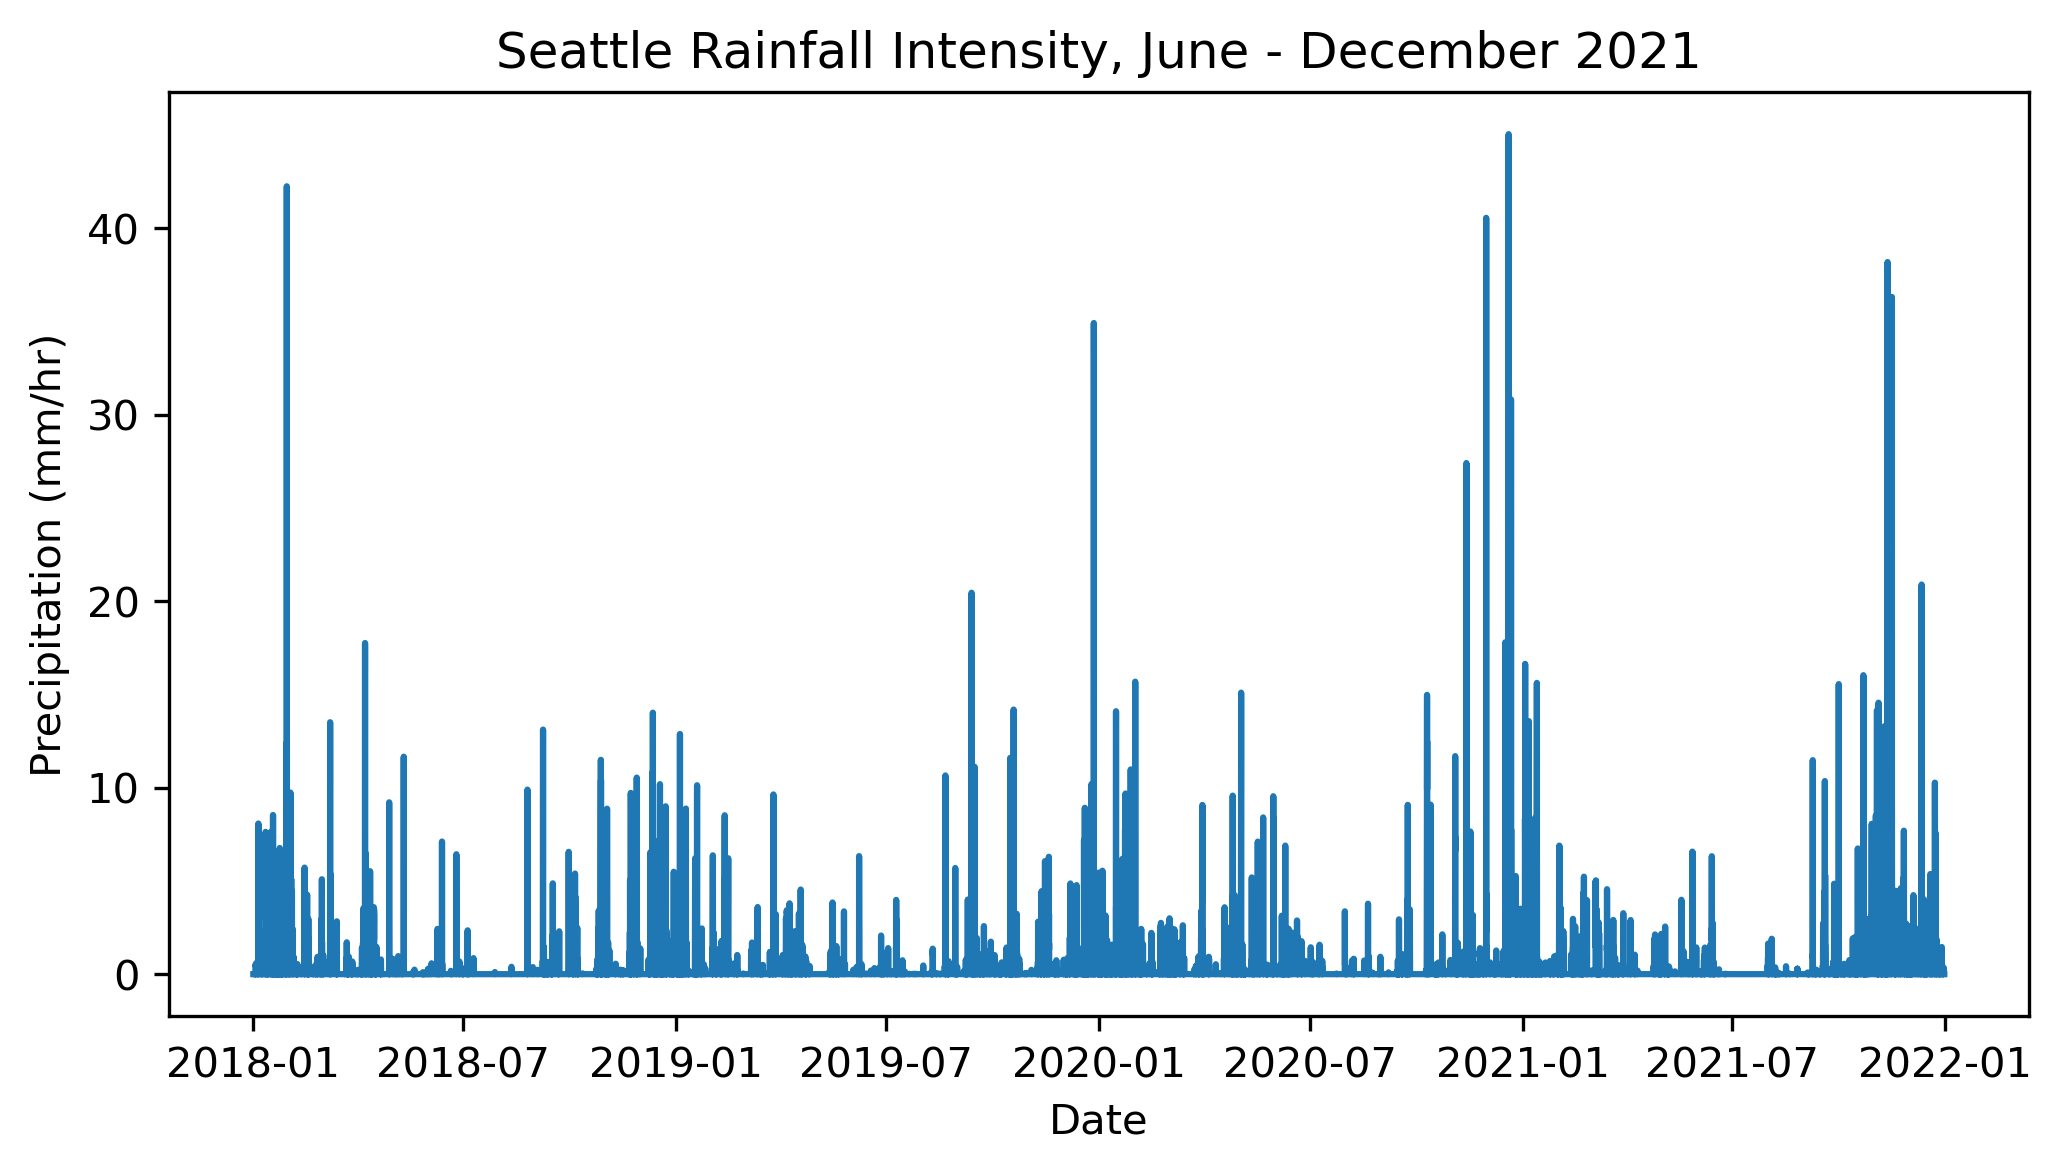

In [10]:
#now plot
plt.figure(figsize=(8, 4), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(df['datetime'],df['precipitationCal'])   # add data to the plot
plt.title('Seattle Rainfall Intensity, June - December 2021', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Precipitation (mm/hr)', fontsize=10)

### 4. Make a Histogram of Precipitation

Now using your time series data, create a histogram of precipitation. Describe it briefly: how skewed are the data (does it look like a 'normal' distribution/bell curve?) How large are the most extreme rainfall events in your region?

Text(0.5, 1.0, 'Frequency of Intense Precipitation Events in Seattle')

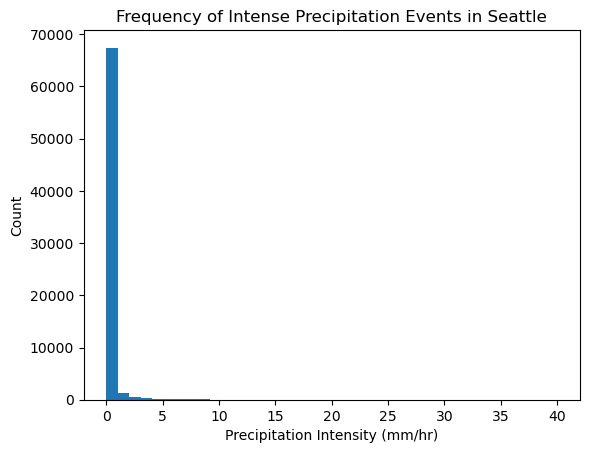

In [11]:
# Create histogram

#first set bins
precbins=np.linspace(0,40,40)
#now plot
n, bins, patches = plt.hist(x=df['precipitationCal'], bins=precbins)

# Label plot axes
plt.xlabel('Precipitation Intensity (mm/hr)')
plt.ylabel('Count')
plt.title('Frequency of Intense Precipitation Events in Seattle')

### 5. Make Some Maps of Interesting Times

Based on the time series of precipitation you just created, look for 1-2 interesting time periods. This could be days when extreme storms happened, or seasons (or years) that were above or below average precipitation.

a. Explain briefly why you chose these particular time periods.

b. Using the GEE Map method that we worked on in class, plot maps of those time periods. Things to think about:
- choosing an appropriate zoom level to highlight the precipitation features you're interested in
- setting appropriate min/max ranges for your plot, to allow the major features of regional precipitation to be easily visualized

c. Using Cartopy, plot maps of the same time periods. Consider the most appropriate map projection to use here, and specify which one you chose.

d. Describe briefly what is interesting about your maps!

In [12]:
#picking some times to map

#write a function to make filtering easier/more repeatable
#filtering to show just maximum values to make 
def getdaterange(date_start, date_end):
    """Returns max values of specified date range from filtered 2018 - 2021 precipitation collecton"""
    daterange = pdatflt.filter(ee.Filter.date(date_start, date_end))
    # rangemax = pdatflt.select('precipitationCal').max()
    # mask = rangemax.gt(0.5)
    # rangemax = rangemax.updateMask(mask)
    return daterange
    
#pick some months to look at average precip intensity
pdatdec21 = getdaterange('2021-12-01', '2021-12-31')
pdatnov21 = getdaterange('2021-11-01', '2021-11-30')
pdatjul21 = getdaterange('2021-07-01', '2021-07-31')
pdataug21 = getdaterange('2021-08-01', '2021-08-31')

#now mask ranges to get just the max values to make intense events more visible on map
def maxmask(daterange):
    """Returns masked range to show only max values"""
    rangemax = daterange.select('precipitationCal').max()
    mask = rangemax.gt(0.5)
    rangemax = rangemax.updateMask(mask)
    return rangemax

#output masked date ranges ready to visualize!
nov = maxmask(pdatnov21)
dec = maxmask(pdatdec21)
jul = maxmask(pdatjul21)
aug = maxmask(pdataug21)

I selected some winter months, November and December, and some summer months, July and August, to look at the precipitation intensity in 2021. I picked this year and these months because they were especially dry and especially wet. There was extensive flooding throughout the region in late 2021. Using the `getdaterange` and `maxmask` functions you can plot the maximum precipitation intensities from any other time periods you're interested in. However, note that the `getdaterange` filter only selects from the dataset back to 2018. I did this to avoid exceeding my GEE memory limit.

## Plots with `geemap`

In [15]:
#using geemap
#create color palette - blue shows low and red shows high intensities
palette = [
  '000096','0064ff', '00b4ff', '33db80', '9beb4a',
  'ffeb00', 'ffb300', 'ff6400', 'eb1e00', 'af0000'
]

# set visualization parameters
visParams = {'bands': ['precipitationCal'],
             'min': 0,
             'max': 42,
             'palette': palette,
             'opacity' : 0.5
            }

#set up empty map for november 
MapNov = geemap.Map(center=[sea_lat, sea_lon], zoom=8)
#Now add a map layer for November 2021 maximum precipitation intensities
MapNov.addLayer(nov, visParams)
MapNov

Map(center=[47.46062, -122.6335], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [13]:
#map December 2021
MapDec = geemap.Map(center=[sea_lat, sea_lon], zoom=8)
MapDec.addLayer(dec, visParams)
MapDec

Map(center=[47.46062, -122.6335], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [14]:
#map July 2021
MapJul = geemap.Map(center=[sea_lat, sea_lon], zoom=8)
MapJul.addLayer(jul, visParams)
MapJul

Map(center=[47.46062, -122.6335], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [15]:
#map August 2021
MapAug = geemap.Map(center=[sea_lat, sea_lon], zoom=8)
MapAug.addLayer(aug, visParams)
MapAug

Map(center=[47.46062, -122.6335], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

# observations on the maps
Interestingly, there are many places where there was no measurable precipitation in July or August of 2021 (the cells wehre there is no coloring - just the backgorund map). This is a sharp contrast to the November and December maps where there's measurable precipitation everywhere, and the intense events are in the maximum range of >40 mm/hr. 

# using cartopy to plot
To make the notebook run faster (the maps above take a while to load) - I'll just plot July and November of 2021, which were the more extreme months. Based on the examples in the documentation that used a Plate Carree projection, I also used a Plate Carree projection.

In [13]:
#plot max values with cartopy
cnov = pdatnov21.max()
cjul = pdatjul21.max()


November and December precipitation intensity maximums:

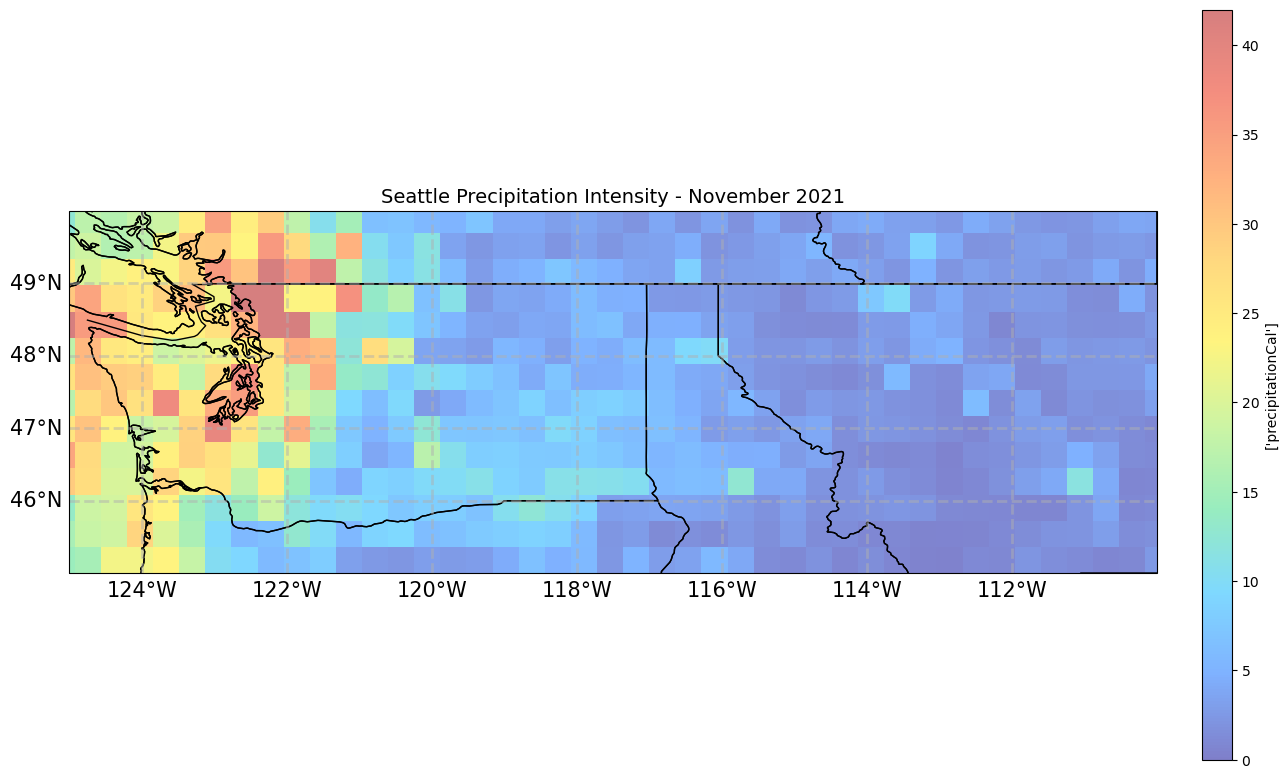

In [17]:
#Map november
fig = plt.figure(figsize=(15, 15))

# create a new Plate-Carree projection 
projection = ccrs.PlateCarree()

# plot the result with cartoee 
ax = cartoee.get_map(cnov, vis_params = visParams, proj = projection, alpha = 0.5)

# Define the lon/lat extent of the plot
ax.set_extent([-125,-110,45,50])   

# Draw in coastlines and features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)

# Draw grid lines
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.5, linestyle='--')

# Set parameters for grid lines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Set plot title
ax.set_title(label='Seattle Precipitation Intensity - November 2021', fontsize=14)

# Add color bar
cartoee.add_colorbar(ax,visParams,loc="right",cmap='coolwarm')

# Display plot
plt.show()

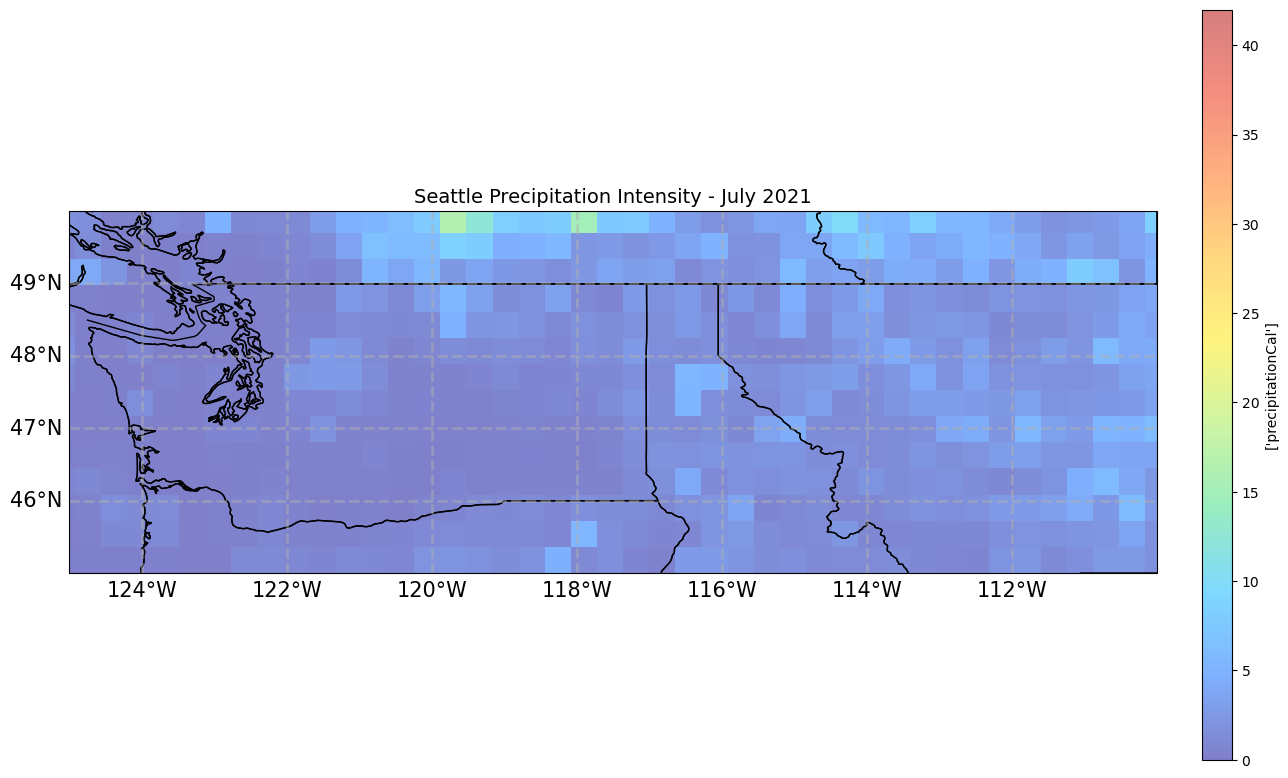

In [20]:
#map july
fig = plt.figure(figsize=(15,15))

# create a new Plate-Carree projection 
projection = ccrs.PlateCarree()

# plot the result with cartoee 
ax = cartoee.get_map(cjul, vis_params = visParams, proj = projection, alpha = 0.5)

# Define the lon/lat extent of the plot
ax.set_extent([-125,-110,45,50])   

# Draw in coastlines and features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)


# Draw grid lines
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.5, linestyle='--')

# Set parameters for grid lines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Set plot title
ax.set_title(label='Seattle Precipitation Intensity - July 2021', fontsize=14)

# Add color bar
cartoee.add_colorbar(ax,visParams,loc="right",cmap='coolwarm')

# Display plot
plt.show()

### 5. Plot Landsat NDVI for the Region

The precipitation analysis discussed above provides useful context for identifying interesting weather events for a particular region. Now let's see what (if any!) effect changes in weather patterns have had on the landscape, using Landsat imagery. 

a. Make a long-term average NDVI map for your region: say, a 10- or 20-year mean. This will give you a baseline to compare against.

b. Make an NDVI map centered on one of your 'interesting' time periods from the precipitation time series. How are the patterns different from the long-term average?


In [21]:
#read in NDVI data from landsat 7 to get long term average
vdat = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA")

In [22]:
#filter region to area around seattle
sea_pt = ee.Geometry.Point([-122.3, 47.6])   # Point corresponding to Seattle, WA

vdat_filt = vdat.filterBounds(sea_pt)

In [50]:
# Use filter to extract all "non-cloudy" images: ones with less than 20% cloud cover
vdat_nocld=vdat_filt.filter('CLOUD_COVER < 0.5')

In [51]:
#filter to select 2001 - 2021
dat_avg20 = vdat_nocld.filter(ee.Filter.date('2001-01-01', '2021-12-31')).mean()

In [52]:
#now calculate NDVI
red = dat_avg20.select('B3')
nir = dat_avg20.select('B4')

ndvi=(nir.subtract(red)).divide((nir.add(red))).rename('NDVI')

#set up color pallette and parameters for plotting
ndviParams = {'min': -1, 
              'max': 1, 
              'palette': ['blue', 'white', 'green']
             }


In [53]:
#Now plot the average NDVI 2001 - 2021
NDVIMap = geemap.Map(center=[47.6, -122.3], zoom=10)

NDVIMap.addLayer(ndvi, ndviParams,'NDVI')

NDVIMap


Map(center=[47.6, -122.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [57]:
#Data in the red band wasn't available in the 2021 date range, and many of the more recent dry summers had issues with the image quality (striped out) so I plotted the summer of 2000

dat_summer = vdat_nocld.filter(ee.Filter.date('2000-07-01', '2000-08-31')).mean()

#now calculate NDVI for this image
red2 = dat_summer.select('B3')
nir2 = dat_summer.select('B4')

ndvi2=(nir.subtract(red2)).divide((nir.add(red2))).rename('NDVI')

NDVIMapSummer = geemap.Map(center=[47.6, -122.3], zoom=10)

NDVIMapSummer.addLayer(ndvi2, ndviParams,'NDVI')

NDVIMapSummer




Map(center=[47.6, -122.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

At first it was very tough to see a difference between the 20 year average NDVI and the dry summers. I played around with plotting a few different summers, and changing the tolerance for cloud cover to include up to 50% cloud cover. THe summer of 2017 is one of the driest summers on record, but still looked similar to the average and it was tough to tell because of the issues in the data (stripes from the sweeping pattern of the satellite I think?). I plotted the summer of 2000 above, as noted in the code comment, becuase it was the easies to see any difference at all - but its still not much. The summer of 2000 is one of driest years on record within the Landsat7 date range. I think perhaps examining a place with a less temperate climate might make the differences easier to see. Also, most of the vegetation cover in Washington is evergreen, which by definition stays green all year round, which might make seeing seasonal differences more challenging. 

The most striking difference in these images is not actually in the shades of green, but in the snow cover on the olympic mountains. In the summer of 2000 the snowpack must have been melting so much it had a lot of liquid water and is starting to show up in the image here as blue instead of white (a negative NDVI instead of 0).